## HECO Cooling Loop A - Energy Disaggregation

#### <span style="color:red; font-weight:bold"> Instructions for Using this Jupyter Notebook:</span>

<span style="color:royalblue">(1) Place **data_clean.py** and this Notebook in the same folder.</span>

<span style="color:royalblue">(2) Only need to modify the **Parameters in Section 1.0** to use this Notebook:</span> 
- Change the **Data Directories** to your own directories 
- Select a **Time Range** for calculating energy disaggregation and then run the Notebook

<span style="color:royalblue">(3) Note that this Notebook uses the data outputs from **data_processing.ipynb** as input data: "delta_kwh.csv" and "delta_tonhrs.csv"</span>
- Ensure that "input_dir" here matches the "output_dir" in *data_processing.ipynb*


## Contents
* [1. Prepare Data](#1)
  * [1.0 Input Parameters](#1.0)
  * [1.1 Imports](#1.1)
  * [1.2 Load Data](#1.2)
* [2. Identify Threshold](#2)  
* [3. Energy Disaggregation](#3)
  * [3.1 Calculate Cooling Energy Usage in Loop A](#3.1)
  * [3.2 Calculate Disaggregated Energy](#3.2)
  * [3.3 Save Data for Uploading](#3.3)

## 1. Prepare Data<a id='1'></a>

### 1.0 Input Parameters<a id='1.0'></a>

In [1]:
########## CHANGE DATA DIRECTORIES & TIME RANGE ##########

# Data Directories
input_dir = '../../data/outputs/'  # "output_dir" in the data_processing.ipynb notebook

output_dir = '../../data/outputs/'  # can be the same as input_dir

plot_dir = '../../data/outputs/plots/'  # directory for plot outputs

# Time Range for caluculation
date_start = "2023-07-01"
date_end = "2024-11-21"  # the last day is not included

# Define thresholds
wh_threshold = 3  # threshold for wh_chwmtr_v1 (number obtained from the plot in Section 2)
ab_threshold = 3  # threshold for ab_chwmtr_v1

# Input files (outputs from data_processing.ipynb)
file_k = "delta_kwh.csv"
file_t = "delta_tonhrs.csv"

######################################################

### 1.1 Imports<a id='1.1'></a>

In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import display, Markdown
# import psycopg2

import data_clean as dc  # import self-defined module

### 1.2 Load Data<a id='1.2'></a>

In [3]:
# Read from csv file
delta_kwh = pd.read_csv(f"{input_dir}{file_k}")
delta_tonhrs = pd.read_csv(f"{input_dir}{file_t}")

##### **Apply time range filter**:

In [4]:
# Convert time range to datetime format
date_start = pd.to_datetime(date_start)
date_end = pd.to_datetime(date_end)

# Convert 'datetime' column to datetime format before filtering
delta_kwh["datetime"] = pd.to_datetime(delta_kwh["datetime"])
delta_tonhrs["datetime"] = pd.to_datetime(delta_tonhrs["datetime"])

# Apply time range filter
delta_kwh = delta_kwh[(delta_kwh["datetime"] >= date_start) & (delta_kwh["datetime"] < date_end)]
delta_tonhrs = delta_tonhrs[(delta_tonhrs["datetime"] >= date_start) & (delta_tonhrs["datetime"] < date_end)]

# reset index
delta_kwh = delta_kwh.reset_index()
delta_tonhrs = delta_tonhrs.reset_index()

##### **Display all columns used in energy_disagg calculation and save the file for data checking:**

In [5]:
# Merge the two dataframes on 'datetime'
df_combined = pd.merge(delta_kwh[['datetime', 'wh_chwmtr_v1', 'ab_chwmtr_v1', 'hh_chwmtr_v2']], 
                       delta_tonhrs[['datetime', 'hh_btu2', 'ab_btu1', 'wh_btu1', 'sh_btu1']], 
                       on='datetime', how='inner')

# Round to 2-decimal float numbers
df_combined.iloc[:, 1:] = df_combined.iloc[:, 1:].apply(lambda x: x.round(2))

# Save file used for calcualation checking
dc.save_file(df_combined, "combined_data_for_disagg_energy_calculation.csv", output_dir)  # output for data checking

Writing file: "../../data/outputs/combined_data_for_disagg_energy_calculation.csv"


In [6]:
# Display the result
display(Markdown(f"<span style='color:blue; font-weight:bold'>Table for columns used in disagg_energy calculation:</span>"))
df_combined.head(3)

<span style='color:blue; font-weight:bold'>Table for columns used in disagg_energy calculation:</span>

,datetime,wh_chwmtr_v1,ab_chwmtr_v1,hh_chwmtr_v2,hh_btu2,ab_btu1,wh_btu1,sh_btu1
0,2023-07-01 00:00:00,11.4,10.7,108.3,80.0,3.33,10.0,0.22
1,2023-07-01 00:15:00,11.2,11.2,107.3,80.0,3.33,10.0,0.22
2,2023-07-01 00:30:00,11.5,10.7,109.3,90.0,2.50,10.0,0.22


## 2. Identify Threshold<a id='2'></a>

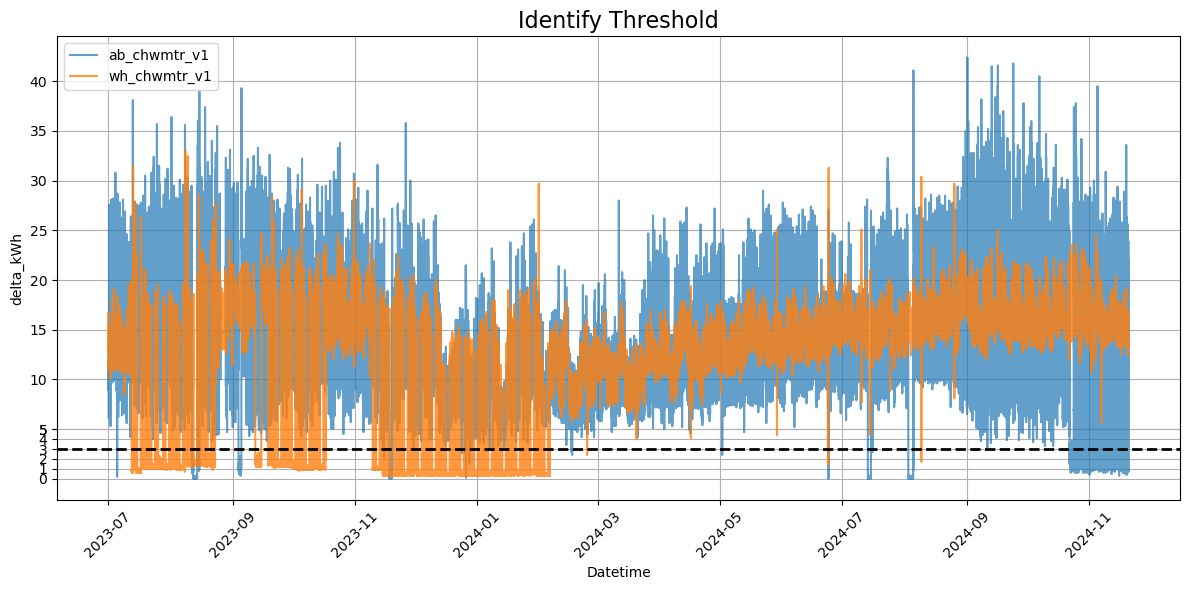

In [7]:
########## PLOT TO FIND THRESHOLD ##########

plt.figure(figsize=(12, 6))

# Plot both wh_chwmtr_v1 and ab_chwmtr_v1
plt.plot(delta_kwh["datetime"], delta_kwh["ab_chwmtr_v1"], label="ab_chwmtr_v1", alpha=0.7)
plt.plot(delta_kwh["datetime"], delta_kwh["wh_chwmtr_v1"], label="wh_chwmtr_v1", alpha=0.8)

# Set y-axis intervals
y_min = 0
y_max = 40
small_ticks = np.arange(y_min, 6, 1)  # 0 to 5 with step of 1
large_ticks = np.arange(5, y_max + 1, 5)  # 5 to 40 with step of 5
y_ticks = np.concatenate((small_ticks, large_ticks))
plt.yticks(y_ticks)

# Formatting the plot
plt.xlabel("Datetime")
plt.ylabel("delta_kWh")
plt.title("Identify Threshold", size=16)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Make grid line at y=3 bold
plt.axhline(y=3, color='black', linewidth=2, linestyle='--')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save plot
pdf_filename = os.path.join(plot_dir, f"Indentify_threshold.pdf")
plt.savefig(pdf_filename, format='pdf')
plt.show()

**Threshold: 3 kWh/15-min** 
- If Watanabe or Art chiller uses > 3 kWh/15-min (i.e. 12 kW load), then its own chiller is providing cooling.
- If Watanabe or Art chiller uses < 3 kWh/15-min, then it's getting cooling from the loop.

## 3. Energy Disaggregation<a id='3'></a>

### 3.1 Calculate Cooling Energy Usage in Loop A<a id='3.1'></a>

In [8]:
# Apply constraints: set wh_btu1 and ab_btu1 to zero when thresholds are exceeded
delta_tonhrs.loc[delta_kwh["wh_chwmtr_v1"] > wh_threshold, "wh_btu1"] = 0
delta_tonhrs.loc[delta_kwh["ab_chwmtr_v1"] > ab_threshold, "ab_btu1"] = 0

# Compute total btu values (excluding hh_btu1)
total_btu = (
    delta_tonhrs["hh_btu2"] +
    delta_tonhrs["ab_btu1"] +
    delta_tonhrs["wh_btu1"] +
    delta_tonhrs["sh_btu1"]
)

# Avoid division by zero
total_btu = total_btu.replace(0, pd.NA)

# Compute usage portions
sh_usage_portion = delta_tonhrs["sh_btu1"] / total_btu
hh_usage_portion = delta_tonhrs["hh_btu2"] / total_btu
wh_usage_portion = delta_tonhrs["wh_btu1"] / total_btu
ab_usage_portion = delta_tonhrs["ab_btu1"] / total_btu

# Store portion results in a new dataframe
usage_portion = pd.DataFrame({
    "datetime": delta_kwh["datetime"],
    "sh_usage": sh_usage_portion,
    "hh_usage": hh_usage_portion,
    "wh_usage": wh_usage_portion,
    "ab_usage": ab_usage_portion
})

# Sum all usage portions
usage_columns = [col for col in usage_portion.columns if col != "datetime"]
usage_portion["total_usage"] = usage_portion[usage_columns].sum(axis=1)
usage_portion = usage_portion.reset_index(drop=True)


# Compute final usage values
sh_usage = sh_usage_portion * delta_kwh["hh_chwmtr_v2"]
hh_usage = hh_usage_portion * delta_kwh["hh_chwmtr_v2"]
wh_usage = wh_usage_portion * delta_kwh["hh_chwmtr_v2"]
ab_usage = ab_usage_portion * delta_kwh["hh_chwmtr_v2"]

# Store results in a new dataframe
usage_results = pd.DataFrame({
    "datetime": delta_kwh["datetime"],
    "sh_usage": sh_usage,
    "hh_usage": hh_usage,
    "wh_usage": wh_usage,
    "ab_usage": ab_usage
})

# Sum all energy usage
usage_columns = [col for col in usage_results.columns if col != "datetime"]
usage_results["total_usage"] = usage_results[usage_columns].sum(axis=1)
usage_results = usage_results.reset_index(drop=True)

# Display the first few rows to verify
display(Markdown(f"<span style='color:blue; font-weight:bold'> Usage of hh_chwmtr_v2 delta_kWh by each building:</span>"))
usage_results.head(3)

<span style='color:blue; font-weight:bold'> Usage of hh_chwmtr_v2 delta_kWh by each building:</span>

,datetime,sh_usage,hh_usage,wh_usage,ab_usage,total_usage
0,2023-07-01 00:00:00,0.293496,108.006504,0.0,0.0,108.3
1,2023-07-01 00:15:00,0.290786,107.009214,0.0,0.0,107.3
2,2023-07-01 00:30:00,0.263373,109.036627,0.0,0.0,109.3


In [9]:
display(Markdown(f"<span style='color:blue; font-weight:bold'> Usage Portion (total is 100%) of hh_chwmtr_v2 delta_kWh by each building:</span>"))
usage_portion.head(3)

<span style='color:blue; font-weight:bold'> Usage Portion (total is 100%) of hh_chwmtr_v2 delta_kWh by each building:</span>

,datetime,sh_usage,hh_usage,wh_usage,ab_usage,total_usage
0,2023-07-01 00:00:00,0.00271,0.99729,0.0,0.0,1.0
1,2023-07-01 00:15:00,0.00271,0.99729,0.0,0.0,1.0
2,2023-07-01 00:30:00,0.00241,0.99759,0.0,0.0,1.0


Plot saved to ../../data/outputs/plots/cooling_usage_portions.pdf


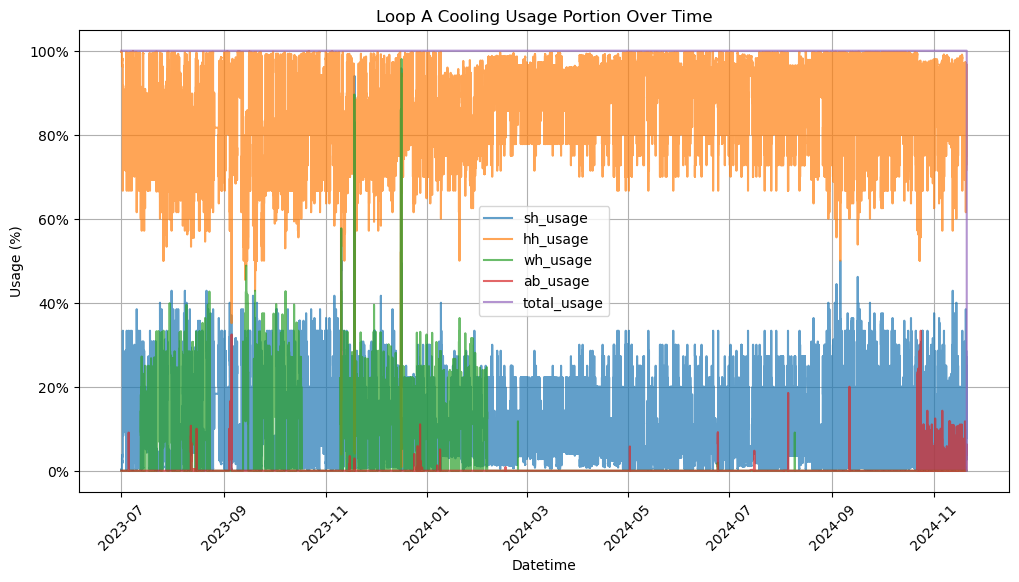

In [10]:
########## PLOT USAGE PORTIONS ##########

plt.figure(figsize=(12, 6))

# Plot all usage columns except 'datetime'
for col in usage_results.columns:
    if col != "datetime":
        plt.plot(usage_portion["datetime"], usage_portion[col], label=col, alpha=0.7)

# Formatting the plot
plt.xlabel("Datetime")
plt.ylabel("Usage (%)")
plt.title("Loop A Cooling Usage Portion Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

# Save the figure to a PDF file
pdf_filename = os.path.join(plot_dir, f"cooling_usage_portions.pdf")
plt.savefig(pdf_filename, format='pdf')
print(f"Plot saved to {pdf_filename}")

plt.show()

### 3.2 Calculate Disaggregated Energy<a id='3.2'></a>

In [11]:
# Initialize an empty list to store the rows for the new 'energy' DataFrame
energy_rows = []

# Loop through each timestamp in the usage_results DataFrame
for idx, row in usage_results.iterrows():
    datetime = row["datetime"]
    
    # 1. hh_usage from usage_results
    energy_rows.append({"datetime": datetime, "building_complex_id": "1163", "end_use": "hh chiller", "kwh": row["hh_usage"]})
    
    # 2. hh_mtr_a + hh_mtr_b - hh_chwmtr_v2 from delta_kwh
    hh_kwh = delta_kwh.loc[idx, "hh_mtr_a"] + delta_kwh.loc[idx, "hh_mtr_b"] - delta_kwh.loc[idx, "hh_chwmtr_v2"]
    energy_rows.append({"datetime": datetime, "building_complex_id": "1163", "end_use": "other", "kwh": hh_kwh})
    
    # 3. wh_usage from usage_results
    energy_rows.append({"datetime": datetime, "building_complex_id": "1160_1190", "end_use": "hh chiller", "kwh": row["wh_usage"]})
    
    # 4. hs_mtr_1 from delta_kwh
    energy_rows.append({"datetime": datetime, "building_complex_id": "1160_1190", "end_use": "health services other", "kwh": delta_kwh.loc[idx, "hs_mtr_1"]})
    
    # 5. wh_chwmtr_v1 from delta_kwh
    energy_rows.append({"datetime": datetime, "building_complex_id": "1160_1190", "end_use": "chiller", "kwh": delta_kwh.loc[idx, "wh_chwmtr_v1"]})
    
    # 6. wh_mtr_1 - wh_chwmtr_v1 from delta_kwh
    wh_kwh = delta_kwh.loc[idx, "wh_mtr_1"] - delta_kwh.loc[idx, "wh_chwmtr_v1"]
    energy_rows.append({"datetime": datetime, "building_complex_id": "1160_1190", "end_use": "watanabe other", "kwh": wh_kwh})
    
    # 7. sh_usage from usage_results
    energy_rows.append({"datetime": datetime, "building_complex_id": "1047", "end_use": "hh chiller", "kwh": row["sh_usage"]})
    
    # 8. sh_mtr_1 from delta_kwh
    energy_rows.append({"datetime": datetime, "building_complex_id": "1047", "end_use": "other", "kwh": delta_kwh.loc[idx, "sh_mtr_1"]})
    
    # 9. ab_usage from usage_results
    energy_rows.append({"datetime": datetime, "building_complex_id": "1049", "end_use": "hh chiller", "kwh": row["ab_usage"]})
    
    # 10. ab_chwmtr_v1 from delta_kwh
    energy_rows.append({"datetime": datetime, "building_complex_id": "1049", "end_use": "chiller", "kwh": delta_kwh.loc[idx, "ab_chwmtr_v1"]})
    
    # 11. ab_mtr_1 - ab_chwmtr_v1 from delta_kwh
    ab_kwh = delta_kwh.loc[idx, "ab_mtr_1"] - delta_kwh.loc[idx, "ab_chwmtr_v1"]
    energy_rows.append({"datetime": datetime, "building_complex_id": "1049", "end_use": "other", "kwh": ab_kwh})

# Convert the list of rows into a DataFrame
energy = pd.DataFrame(energy_rows)

# Round the entire 'kwh' column to 2 decimal places
energy['kwh'] = energy['kwh'].round(2)

# Show the first few rows of the new 'energy' DataFrame
display(Markdown(f"<span style='color:blue; font-weight:bold'>Table for Disaggregated Energy:</span>"))
energy.head(11)

<span style='color:blue; font-weight:bold'>Table for Disaggregated Energy:</span>

,datetime,building_complex_id,end_use,kwh
0,2023-07-01,1163,hh chiller,108.01
1,2023-07-01,1163,other,67.70
2,2023-07-01,1160_1190,hh chiller,0.00
3,2023-07-01,1160_1190,health services other,1.00
4,2023-07-01,1160_1190,chiller,11.40
5,2023-07-01,1160_1190,watanabe other,29.60
6,2023-07-01,1047,hh chiller,0.29
7,2023-07-01,1047,other,10.00
8,2023-07-01,1049,hh chiller,0.00
9,2023-07-01,1049,chiller,10.70


### 3.3 Save Data for Uploading<a id='3.3'></a>

In [12]:
# Extract the min and max datetime
min_datetime = energy["datetime"].min().strftime('%Y-%m-%d_%H-%M-%S')
max_datetime = energy["datetime"].max().strftime('%Y-%m-%d_%H-%M-%S')

# Create the file name with the variable
file_name = f"disagg_energy_{min_datetime}_{max_datetime}.csv"

# Save file
dc.save_file(energy, file_name, output_dir)  # for uploading

Writing file: "../../data/outputs/disagg_energy_2023-07-01_00-00-00_2024-11-20_23-45-00.csv"
